# Basic signal detection

Notebook intended to play around with detecting signals in noise.

Detecting a signal embedded in noise is a very common and universal task. For example, one may wish to detect whether a planet is present by the attenuation of incoming light from a star. However, all measurements have inevitable noise, be it process noise or measurement noise. Discerning what is signal from what is noise then becomes extremely important.

In this notebook I apply basic statistical signal processing methods to create powerful detection tools. First, I start with the simplest case, and step by step make the problem more complicated.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.special as ss

# Define units
s = 1
Hz = 1 / s

## 1. Detection of a signal in white Gaussian noise

When we know how a signal looks, the task is easiest. This can happen, for example, in a radar system, where the shape of the pulse to be received is known beforehand. 

First we define our signal. In this case I use a simple boxcar, but any other template will do (like a Gaussian pulse, a heart beat, a gravitational wave merger, etc.). A  boxcar has 3 parameters: its position $t_0$, its width $w$ and its strength $A$. I define a normalized boxcar, and keep the amplitude as a coefficient to the template. 

$$
h(t) = \begin{cases} \frac{1}{w},\ t \in [t_0 - w/2, t_0 + w/2] \\ 0, \ \text{elswehere}\end{cases},
$$

where normalization ensures $||h(t)||^2 = \sqrt{\sum_t |h(t)|^2} = 1$. For now I will assume $A=1$.

In [3]:
def boxcar_pulse(t, center, width):
    """ Template function for a boxcar pulse, created on time grid x sampled at fs. """
    signal = np.where(
        (t > center - width/2) & (t < center + width/2),
        1,
        0,
    )
    return signal /  np.linalg.norm(signal)

### 1.1 Signal with known parameters

Now that we have designed a template that we want to find, we can set up the simplest version of the problem. We want to know if a signal contains the pulse defined above. The signal contains white gaussian noise (WGN). Defining our statistical model we have,

$$
\begin{align*}
\mathcal{H}_0\ &:\ d(t) = n(t), \\
\mathcal{H}_1\ &:\ d(t) = h(t) + n(t), \\
n(t) &\sim \mathcal{N}(0, \sigma^2).
\end{align*}
$$

Under the null hypothesis, the data contains no signal. The alternative hypothesis states that the signal is present in the data.

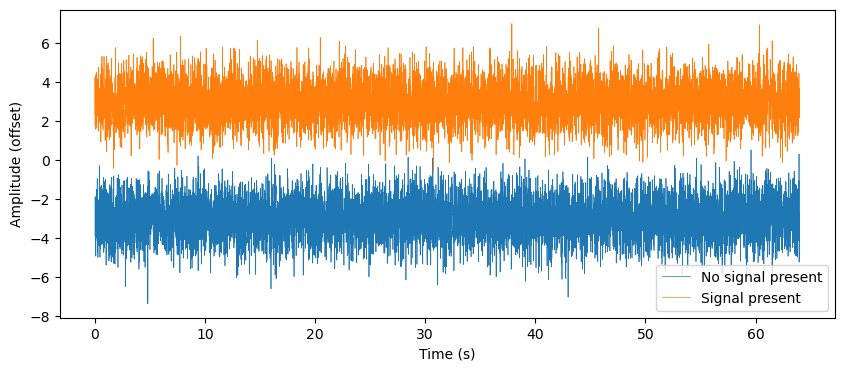

In [103]:
# Data parameters
len_t = 64 * s
fs = 128 * Hz
t_grid = np.arange(0, len_t, 1/fs)

# Template parameters
center = 32 * s
width = 3 * s
h = boxcar_pulse(t_grid, center, width)

# Noise parameters
sigma = 1 

# Simulation parameters
N_repetitions = 10000


d_no_signal = np.random.normal(0, sigma, (N_repetitions, len(t_grid)))
d_signal = h + np.random.normal(0, sigma, (N_repetitions, len(t_grid)))

plt.figure(figsize=(10, 4))
plt.plot(t_grid, d_no_signal[0] - 3, label='No signal present', lw=0.5)
plt.plot(t_grid, d_signal[0] + 3, label='Signal present', lw=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (offset)')
plt.legend()
plt.show()

It becomes aparent that we cannot know if there is a signal present by the naked eye. For this we need the power of statistics. 

Applying the Neyman-Pearson lemma we can derive the optimal test-statistic by use of the likelihood ratio test.

Under both hypotheses we have the pdfs,

$$
\begin{align*}
p(\vec{d}|\mathcal{H}_0) &= \prod_t \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2}\frac{|d(t)|^2}{\sigma^2}} = \frac{1}{\sqrt{(2\pi\sigma^2)^N}}e^{-\frac{1}{2}\sum_t \frac{|d(t)|^2}{\sigma^2}}, \\
p(\vec{d}|\mathcal{H}_1) &= \prod_t \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2}\frac{|d(t) - h(t)|^2}{\sigma^2}} = \frac{1}{\sqrt{(2\pi\sigma^2)^N}}e^{-\frac{1}{2}\sum_t \frac{|d(t) - h(t)|^2}{\sigma^2}}.
\end{align*}
$$

We now take the likelihood ratio test to obtain the optimal test statistic, as according to the Neyman-Pearson lemma, 
$$
\mathcal{T} = \frac{p(\vec{d}|\mathcal{H}_1)}{p(\vec{d}|\mathcal{H}_0)} \gtrless \eta
$$

is the test statistic maximizing the power at a given threshold $\eta$, set by the type I error. In other words, there are no other statistics which are more discriminating than the one obtained through the LRT. 

Applying monotone transformations one can greatly simplify this test statistic.

$$
\begin{align*}
\mathcal{T} \cong -\sum_t \frac{|d(t) - h(t)|^2}{\sigma^2} + \sum_t \frac{|d(t)|^2}{\sigma^2} = \sum_t \frac{ 2 d(t)h(t) - |h(t)|^2}{\sigma^2}.
\end{align*}
$$

We further simplify by removing elements independent of the data (constants) to arrive at the famous matched filter,

$$
\mathcal{T} \cong \sum_t \frac{d(t)h(t)}{\sigma^2} = \frac{\vec{d}^\intercal\vec{h}}{\sigma^2}.
$$

As stated earlier, this is the statistically most powerful test to discern the signal within the noise. To understand how the statistic distributes, let's calculate expectation values and variances.

$$
\begin{align*}
\mathbb{E}[\mathcal{T}|\mathcal{H}_0] &= \mathbb{E}\left[ \frac{\sum_t d(t)h(t)}{\sigma^2}\right] = \frac{\sum_t h(t)\mathbb{E}[d(t)]}{\sigma^2} = 0, \\
\mathbb{E}[\mathcal{T}|\mathcal{H}_1] &= \mathbb{E}\left[ \frac{\sum_t d(t)h(t)}{\sigma^2}\right] = \frac{\sum_t h(t)\mathbb{E}[d(t)]}{\sigma^2} = \frac{\sum_t |h(t)|^2}{\sigma^2} = \frac{1}{\sigma^2} \\
\end{align*}
$$

The template normalization allows the expression to be simplified. Now we calculate the variance, which is independent of the hypothesis.

$$
\mathbb{V}[\mathcal{T}] = \mathbb{V}\left[ \frac{\sum_t d(t)h(t)}{\sigma^2} \right] = \frac{\sum_t|h(t)|^2\mathbb{V}[d(t)]}{\sigma^4} = \frac{\sum_t |h(t)|^2}{\sigma^2} = \frac{1}{\sigma^2}.
$$

Now we know how the test statistic distributes, as it is a linear combination of other gaussians,

$$
\mathcal{T}|\mathcal{H}_0 \sim \mathcal{N}(0, 1/\sigma^2), \quad \mathcal{T}|\mathcal{H}_1 \sim \mathcal{N}(1/\sigma^2, 1/\sigma^2).
$$

To put this to the test, we generate many realizations of the data, some with a pulse in them, some without. Then we calculate the derived test statistic and plot its distribution.

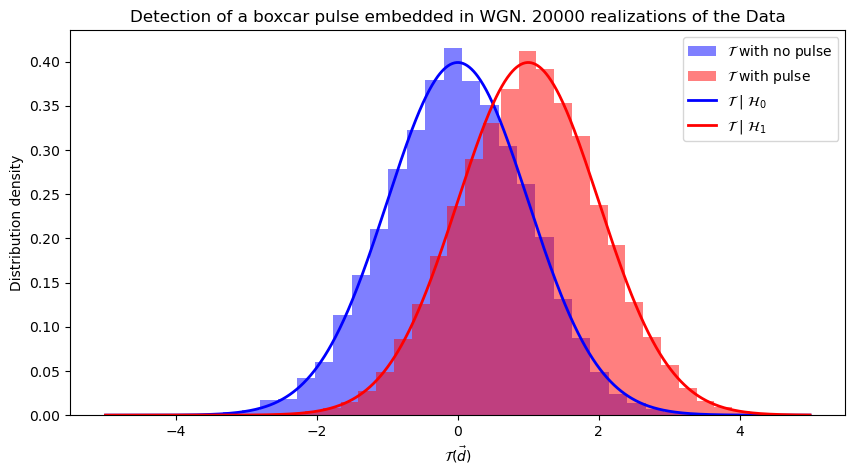

In [ ]:
T_no_pulse = np.sum(d_no_signal * h / sigma**2, axis=1)
T_pulse = np.sum(d_signal * h / sigma**2, axis=1)

x_grid = np.linspace(-5, 5, 1000)
H0_dist = sps.norm.pdf(x_grid, 0, 1/sigma)
H1_dist = sps.norm.pdf(x_grid, 1/sigma**2, 1/sigma)

plt.figure(figsize=(10, 5))
plt.hist(T_no_pulse, bins=30, alpha=0.5, label='$\mathcal{T}$ with no pulse', color='blue', density=True)
plt.hist(T_pulse, bins=30, alpha=0.5, label='$\mathcal{T}$ with pulse', color='red', density=True)
plt.plot(x_grid, H0_dist, label='$\mathcal{T}$ | $\mathcal{H}_0$', color='blue', lw=2)
plt.plot(x_grid, H1_dist, label='$\mathcal{T}$ | $\mathcal{H}_1$', color='red', lw=2)
plt.legend()
plt.title(f"Detection of a boxcar pulse embedded in WGN. {2*N_repetitions} realizations of the Data")
plt.ylabel("Distribution density")
plt.xlabel(r'$\mathcal{T}(\vec{d})$')
plt.show()

Despite being completely invisible by the naked eye, the optimal test statistic derived can discern between noise containing the signal, and empty noise.

Before setting the threshold $\eta$ to make a decision, we can visualize the power of this statistic by plotting the receiver operating characteristic (ROC) curve. This plot shows type I ($\beta_1$) vs type II ($\beta_0$) errors as the threshold $\eta$ is varied, essentially portraying how "separated" the above gaussians are. Defining both types of error,

$$
\begin{align*}
\beta_1 &= P(\mathcal{T}>\eta|\mathcal{H}_0) = \frac{1}{\sqrt{2\pi\sigma^2_{\mathcal{T}}}} \int_\eta^\infty e^{-\frac{x^2}{2\sigma^2_{\mathcal{T}}}} dx = \frac{1}{2}\left(1 - \text{erf}\left(\frac{\eta}{\sqrt{2}\sigma_\mathcal{T}}\right) \right), \\
\beta_0 &= P(\mathcal{T}<\eta|\mathcal{H}_1) =  \frac{1}{\sqrt{2\pi\sigma^2_{\mathcal{T}}}} \int_{-\infty}^\eta e^{-\frac{(x-\mu_{\mathcal{T}})^2}{2\sigma^2_{\mathcal{T}}}} dx = \frac{1}{2}\left(1 + \text{erf}\left(\frac{\eta - \mu_\mathcal{T}}{\sqrt{2}\sigma_\mathcal{T}}\right) \right).

\end{align*}
$$

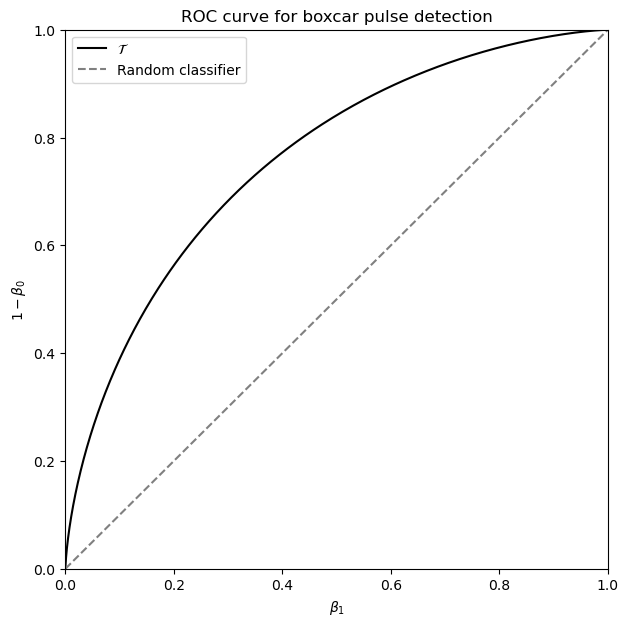

In [92]:
def calc_beta_1(eta_grid, sigma_T):
    return 1/2 * (1 - ss.erf(eta_grid / (2**0.5 * sigma_T)) )

def calc_beta_0(eta_grid, sigma_T, mu_T):
    return 1/2 * (1 + ss.erf((eta_grid - mu_T) / (2**0.5 * sigma_T)) )

eta_grid = np.linspace(-4, 4, 1000)
betas_0 = calc_beta_1(eta_grid, 1/sigma**2)
betas_1 = calc_beta_0(eta_grid, 1/sigma**2, 1/sigma**2)

plt.figure(figsize=(7, 7))
plt.plot(betas_1, 1 - betas_0, label='$\mathcal{T}$', color='black')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random classifier')
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$1 -\beta_0$')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('ROC curve for boxcar pulse detection')
plt.show()

Now we wish to make a decision. Given an observation, is the signal present? For this we have developed the optimal test statistic, and now we need to make some decisions to fix the threshold $\eta$. Assume that for this specific application, we cannot afford a false alarm rate ($\beta_1$) above 5%. This will fix $\eta$. Rearanging the expresion for $\beta_1$,
$$
\eta = \sigma_\mathcal{T}\sqrt{2}\text{erf}^{-1}\left(1-2\beta_1\right)
$$



In [7]:
def calc_eta(sigma_T, beta_1):
    """ Compute the threshold eta for a given beta_1 and sigma_T. """
    return 2**0.5 * sigma_T * ss.erfinv(1 - 2 * beta_1)

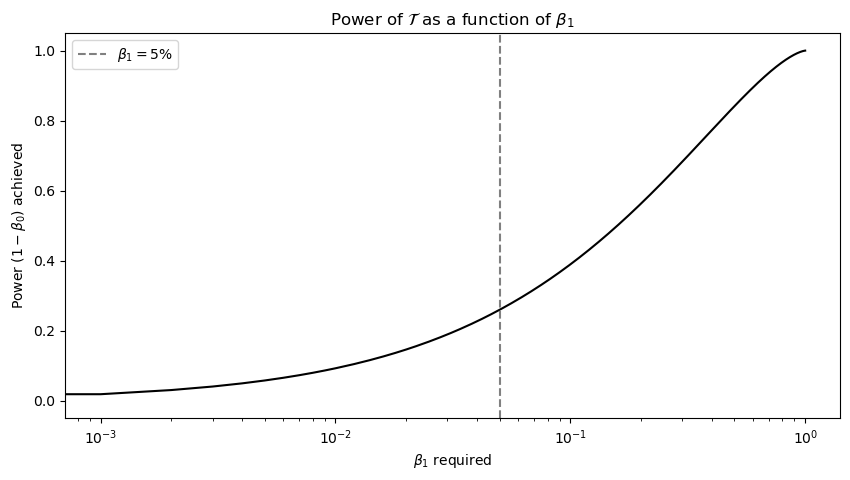

In [94]:
beta_1_grid = np.linspace(0, 1, 1000)
eta = calc_eta(1/sigma, beta_1_grid)
beta_0 = calc_beta_0(eta, 1/sigma**2, 1/sigma)

plt.figure(figsize=(10, 5))
plt.plot(beta_1_grid, 1-beta_0, color='black')
plt.xlabel(r'$\beta_1$ required')
plt.ylabel(r'Power ($1 - \beta_0$) achieved')
plt.axvline(0.05, linestyle='--', color='gray', label=r'$\beta_1 = 5\%$')
plt.title(r"Power of $\mathcal{T}$ as a function of $\beta_1$")
plt.xscale('log')
plt.legend()
plt.show()

In [98]:
power = 1 - calc_beta_0(calc_eta(1/sigma, 0.05), 1/sigma, 1/sigma**2)
print(f"Power of the test at beta_1 = 0.05: {power:.4f}")

Power of the test at beta_1 = 0.05: 0.2595


This graph shows the power of our test. At a fixed false alarm rate of $\beta_1 = 5\%$, the derived test statistic achieves a power of $1 - \beta_0 = 26\%$. No other test out there will achieve a higher power than this.

### 1.2 Pulse with an unkown amplitude

The first generalization we make is removing the constraint of $A=1$. Now we have one unknown parameter in our data, and as such the hypothesis becomes a composite hypothesis. Since the Neyman-Pearson lemma only works for simple hypothesis, we will have to circumvent this. The statistical model is,

$$
\begin{align*}
\mathcal{H}_0\ &:\ d(t) = n(t), \\
\mathcal{H}_1(A)\ &:\ d(t) = Ah(t) + n(t), \\
n(t) &\sim \mathcal{N}(0, \sigma^2).
\end{align*}
$$

In this case, we can assume that we know $A$, and derive the matched filter test statistic just as done above. 

$$
\mathcal{T} = \sum_t \frac{A h(t) d(t)}{\sigma^2} \gtrless \eta
$$

Once again, applying a monotone transform,

$$
\mathcal{T} = \sum_t \frac{h(t) d(t)}{\sigma^2} \gtrless \eta(A)
$$

Here we see that, independent of $A$ (this will only change where the threshold sits), the most powerful test is still the same. This phenomenon is coined the uniquely most powerful test (UMP). It is a result of the more general Karlin-Rubin theorem.

This test will distribute as
$$
\mathcal{T}|\mathcal{H}_0 \sim \mathcal{N}(0, 1/\sigma^2), \quad \mathcal{T}|\mathcal{H}_1 \sim \mathcal{N}(A/\sigma^2, 1/\sigma^2).
$$

Let's now put it to the test, in a similar fashion as done above. Intuitively, we expect the classification to become better as the amplitude of the signal grows (we might even get to detect it by eye).


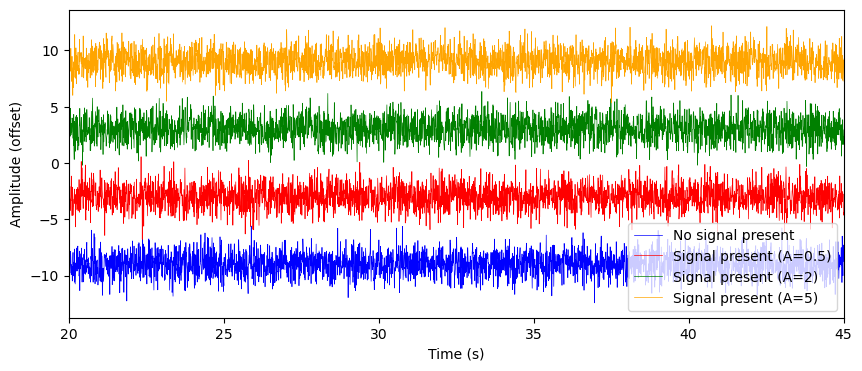

In [99]:
# Template parameters
center = 32 * s
width = 0.5 * s
h = boxcar_pulse(t_grid, center, width)

# Noise parameters
sigma = 1

# Simulation parameters
N_repetitions = 10000


d_no_signal = np.random.normal(0, sigma, (N_repetitions, len(t_grid)))
d_05 = 0.5 * h + np.random.normal(0, sigma, (N_repetitions, len(t_grid)))
d_2 = 2 * h + np.random.normal(0, sigma, (N_repetitions, len(t_grid)))
d_5 = 5 * h + np.random.normal(0, sigma, (N_repetitions, len(t_grid)))

plt.figure(figsize=(10, 4))
plt.plot(t_grid, d_no_signal[0] - 9, label='No signal present', lw=0.5, c='blue')
plt.plot(t_grid, d_05[0] - 3, label='Signal present (A=0.5)', lw=0.5, c='red')
plt.plot(t_grid, d_2[0] + 3, label='Signal present (A=2)', lw=0.5, c='green')
plt.plot(t_grid, d_5[0] + 9, label='Signal present (A=5)', lw=0.5, c='orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (offset)')
plt.xlim(20, 45)
plt.legend()
plt.show()

The pulse starts becoming visible by the naked eye. But our statistic can do better.

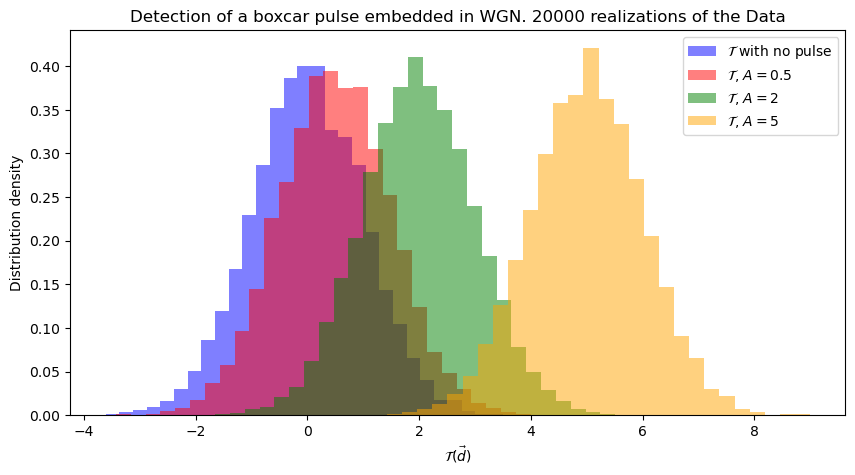

In [100]:
T_no_pulse = np.sum(d_no_signal * h / sigma**2, axis=1)
T_05 = np.sum(d_05 * h / sigma**2, axis=1)
T_2 = np.sum(d_2 * h / sigma**2, axis=1)
T_5 = np.sum(d_5 * h / sigma**2, axis=1)


plt.figure(figsize=(10, 5))
plt.hist(T_no_pulse, bins=30, alpha=0.5, label='$\mathcal{T}$ with no pulse', color='blue', density=True)
plt.hist(T_05, bins=30, alpha=0.5, label='$\mathcal{T}$, $A=0.5$', color='red', density=True)
plt.hist(T_2, bins=30, alpha=0.5, label='$\mathcal{T}$, $A=2$', color='green', density=True)
plt.hist(T_5, bins=30, alpha=0.5, label='$\mathcal{T}$, $A=5$', color='orange', density=True)
plt.legend()
plt.title(f"Detection of a boxcar pulse embedded in WGN. {2*N_repetitions} realizations of the Data")
plt.ylabel("Distribution density")
plt.xlabel(r'$\mathcal{T}(\vec{d})$')
plt.show()

As done above, we can plot the ROC to see which signal will be detected better. We know how the statistic distributes as a function of $A$, so we can calculate the type I and type II errors.

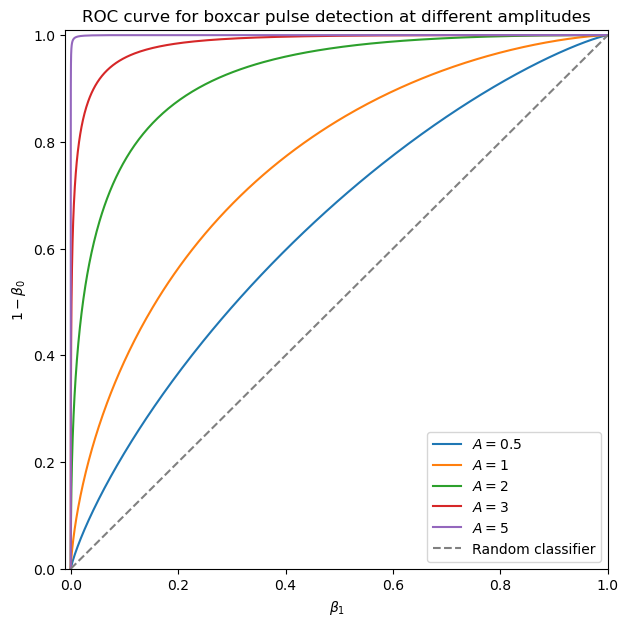

In [106]:
eta_grid = np.linspace(-5, 8, 1000)
betas_1 = calc_beta_1(eta_grid, 1/sigma)

plt.figure(figsize=(7, 7))
for A in [0.5, 1, 2, 3, 5]:
    betas_0 = calc_beta_0(eta_grid, 1/sigma, A/sigma**2)
    plt.plot(betas_1, 1 - betas_0, label=f'$A={A}$')
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$1-\beta_0$")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random classifier')
plt.legend()
plt.xlim(-0.01, 1)
plt.ylim(0, 1.01)
plt.title('ROC curve for boxcar pulse detection at different amplitudes')
plt.show()

From the ROC we can see that for $A=5$, the statistic is almost perfect, hugging the top left corner nearly maximally.

Now we can ask ourself: what is the minimum amplitude pulse that we can detect 50% of the time? That is, for what $A$ is the power of our test $1-\beta_0 = 0.5$, while keeping our $\beta_1$ at 5%?

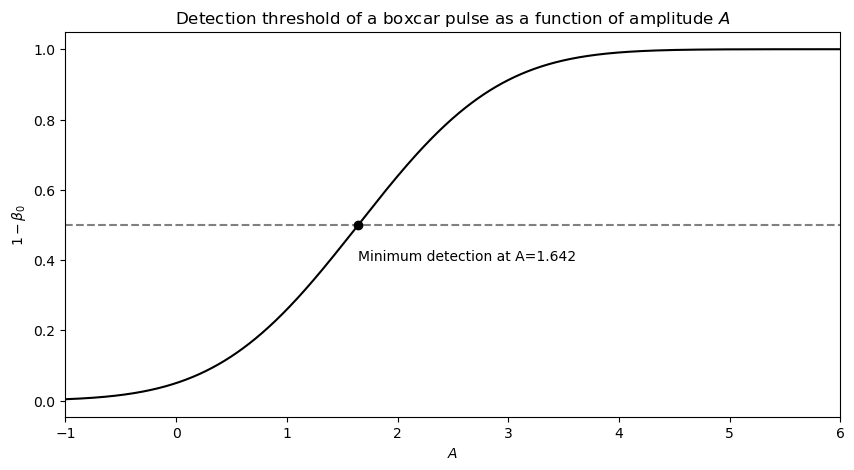

In [ ]:
eta = calc_eta(1/sigma, 0.05)

A_grid = np.linspace(-1, 6, 1000)
beta_0 = calc_beta_0(eta, 1/sigma, A_grid / sigma**2)
A_limit = np.argwhere(np.diff(np.sign(1 - beta_0 - 0.5))).flatten()[0]


plt.figure(figsize=(10, 5))
plt.plot(A_grid, 1 - beta_0, color='black')
plt.axhline(0.5, ls='--', c='gray')
plt.plot(A_grid[A_limit], 0.5, 'ko')
plt.text(A_grid[A_limit], 0.4, f"Minimum detection at A={float(A_grid[A_limit]):.3f}")
plt.xlabel(r'$A$')
plt.ylabel(r'$1 - \beta_0$')
plt.title(r"Detection threshold of a boxcar pulse as a function of amplitude $A$")
plt.xlim(-1, 6)
plt.show()
